Shape: (200, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Head:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   76    1   3       126   239    0        2      119      1      0.5      1   
1   33    1   1       121   557    0        2      119      0      0.9      1   
2   54    0   3       138   463    0        0      192      1      0.9      0   
3   32    0   1       130   547    0        0       89      0      0.6      1   
4   48    0   2       111   172    0        0      196      0      0.9      0   

   ca  thal  target  
0   0     1       0  
1   3     0       1  
2   1     0       1  
3   4     0       1  
4   2     2       1  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       200 non-null    int6

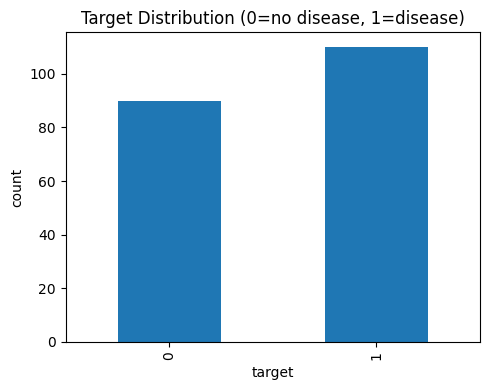

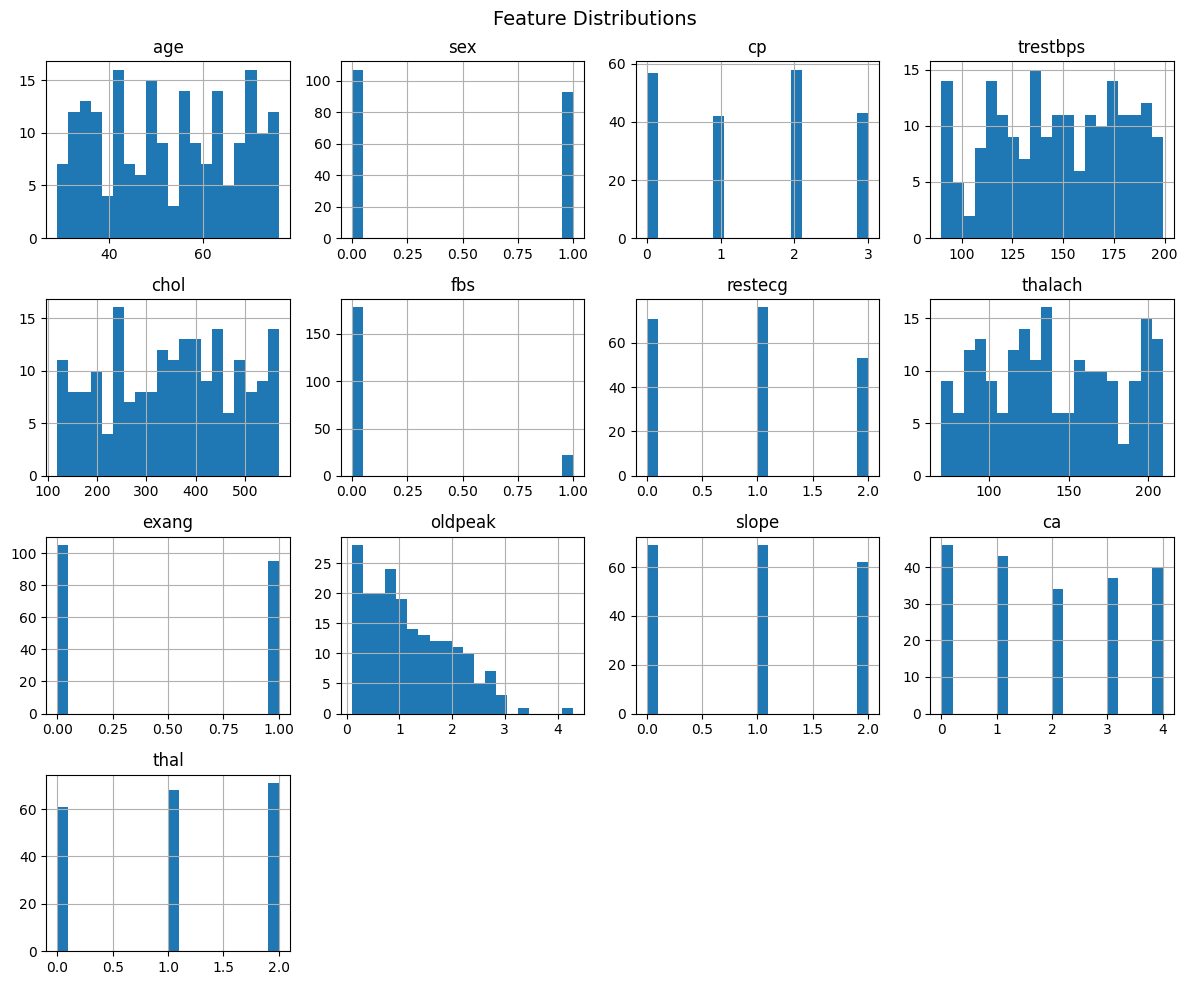

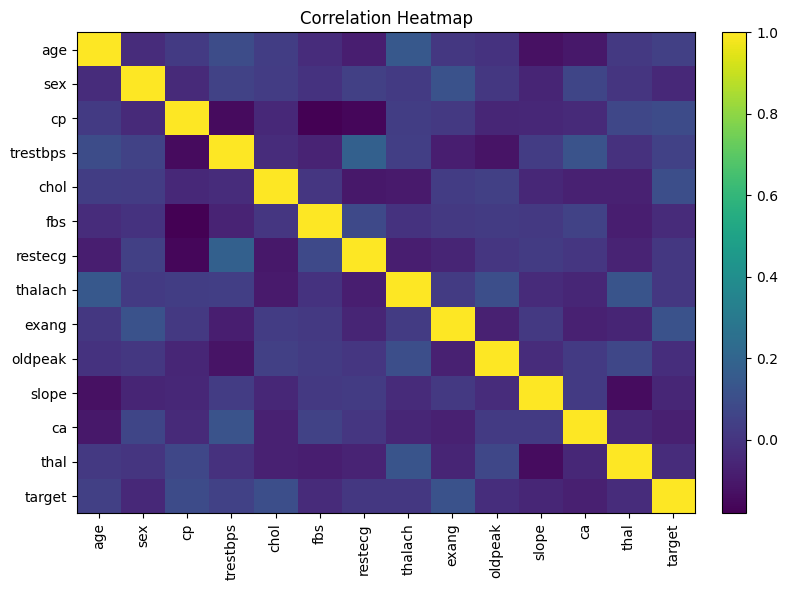


Accuracy: 0.4250
Confusion Matrix [[TN, FP],[FN, TP]]:
[[ 4 10]
 [13 13]]


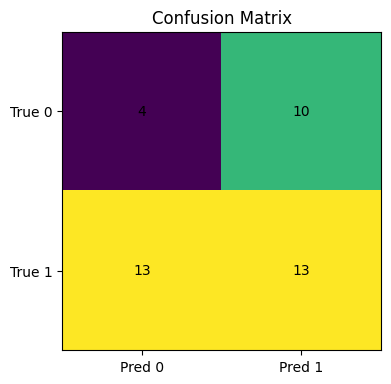

<ipython-input-4-201809363ae9>:189: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_sorted, fpr_sorted)


AUC: 0.4025


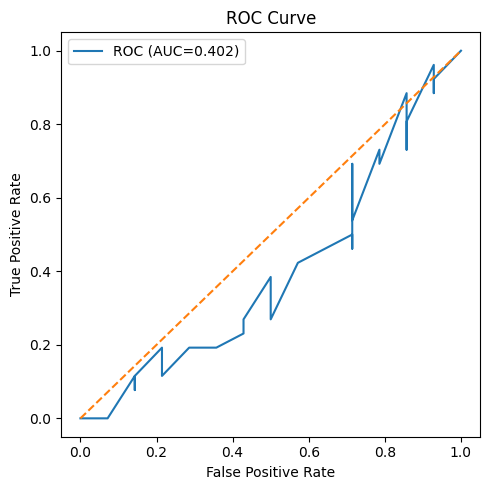


Feature importance (abs(weight) on standardized features):
slope       0.208019
cp          0.194438
fbs         0.193573
age         0.150369
trestbps    0.130806
chol        0.114941
restecg     0.114782
oldpeak     0.102379
thal        0.092843
thalach     0.087278
dtype: float64


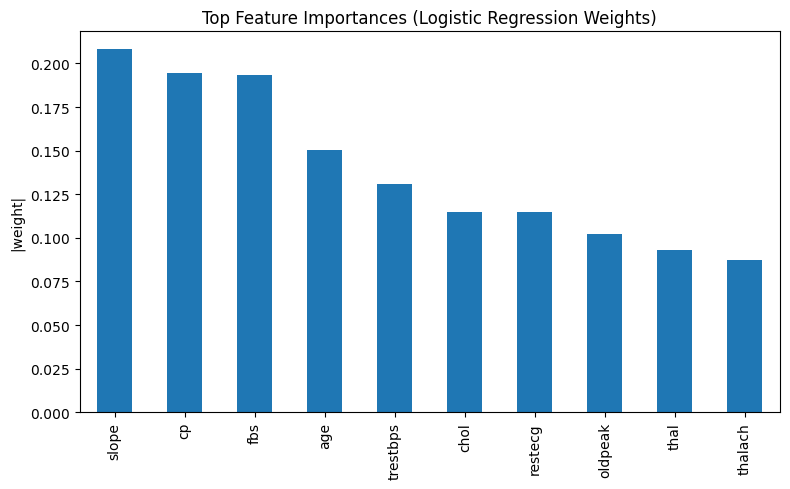

In [4]:
# ===============================
# Heart Disease Prediction (No external installs)
# ===============================
# Works with the Kaggle UCI Heart dataset (often named 'heart.csv')
# or with the provided synthetic 'heart_sample.csv'.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------- 0) Settings: set your filename here ---------
CSV_FILE = "heart_sample.csv"   # <- change to your uploaded file name
# CSV_FILE = "heart_sample.csv"  # fallback demo file

# --------- 1) Load & Basic Cleaning ---------
df = pd.read_csv(CSV_FILE)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nHead:")
print(df.head())

print("\nInfo:")
print(df.info())

# Standardize common column naming differences:
# Some variants use 'target' (0/1). Others use 'num' (0..4). Convert to binary if needed.
if "target" in df.columns:
    y_col = "target"
elif "num" in df.columns:
    y_col = "num"
    # Convert to binary: presence of disease > 0
    df["target"] = (df["num"] > 0).astype(int)
    y_col = "target"
else:
    raise ValueError("No 'target' or 'num' column found. Please adjust the code to your file.")

# Coerce non-numerics (e.g., '?') to NaN then impute
for col in df.columns:
    if col == y_col:
        continue
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Missing values: median for numeric
num_cols = [c for c in df.columns if c != y_col]
for col in num_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

# Drop duplicates if any
df = df.drop_duplicates().reset_index(drop=True)

print("\nMissing values per column:")
print(df.isna().sum())

# --------- 2) Quick EDA ---------
print("\nDescribe (numeric):")
print(df[num_cols + [y_col]].describe())

# Target distribution
target_counts = df[y_col].value_counts().sort_index()
plt.figure(figsize=(5,4))
target_counts.plot(kind="bar")
plt.title("Target Distribution (0=no disease, 1=disease)")
plt.xlabel("target")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# Histograms of features
df[num_cols].hist(bins=20, figsize=(12,10))
plt.suptitle("Feature Distributions", fontsize=14)
plt.tight_layout()
plt.show()

# Simple correlation heatmap (matplotlib only)
corr = df[num_cols + [y_col]].corr()
plt.figure(figsize=(8,6))
im = plt.imshow(corr, aspect='auto')
plt.title("Correlation Heatmap")
plt.xticks(ticks=range(len(corr.columns)), labels=corr.columns, rotation=90)
plt.yticks(ticks=range(len(corr.index)), labels=corr.index)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# --------- 3) Train / Test Split (80/20, stratified-ish via shuffle) ---------
rng = np.random.default_rng(42)
idx = np.arange(len(df))
rng.shuffle(idx)

split = int(0.8 * len(df))
train_idx, test_idx = idx[:split], idx[split:]

X = df[num_cols].values
y = df[y_col].values.astype(int)

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# --------- 4) Standardize features (fit on train, apply to test) ---------
mean_ = X_train.mean(axis=0)
std_ = X_train.std(axis=0, ddof=0)
std_[std_ == 0] = 1.0

X_train_std = (X_train - mean_) / std_
X_test_std  = (X_test  - mean_) / std_

# --------- 5) Logistic Regression (from scratch, with L2) ---------
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def train_logreg_gd(X, y, lr=0.05, epochs=3000, l2=0.0):
    n, d = X.shape
    w = np.zeros(d)        # weights
    b = 0.0                # bias
    for _ in range(epochs):
        z = X @ w + b
        p = sigmoid(z)
        # gradients
        grad_w = (X.T @ (p - y)) / n + l2 * w
        grad_b = np.mean(p - y)
        # update
        w -= lr * grad_w
        b -= lr * grad_b
    return w, b

w, b = train_logreg_gd(X_train_std, y_train, lr=0.05, epochs=3000, l2=0.001)

def predict_proba(X, w, b):
    return sigmoid(X @ w + b)

def predict_label(X, w, b, thr=0.5):
    return (predict_proba(X, w, b) >= thr).astype(int)

# --------- 6) Evaluation: Accuracy, Confusion Matrix, ROC, AUC ---------
y_proba = predict_proba(X_test_std, w, b)
y_pred = (y_proba >= 0.5).astype(int)

# Accuracy
acc = (y_pred == y_test).mean()
print(f"\nAccuracy: {acc:.4f}")

# Confusion Matrix
tp = int(((y_pred == 1) & (y_test == 1)).sum())
tn = int(((y_pred == 0) & (y_test == 0)).sum())
fp = int(((y_pred == 1) & (y_test == 0)).sum())
fn = int(((y_pred == 0) & (y_test == 1)).sum())
cm = np.array([[tn, fp],
               [fn, tp]])
print("Confusion Matrix [[TN, FP],[FN, TP]]:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap=None)
plt.title("Confusion Matrix")
plt.xticks([0,1], ["Pred 0","Pred 1"])
plt.yticks([0,1], ["True 0","True 1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

# ROC Curve & AUC
thresholds = np.linspace(0, 1, 201)
tpr_list, fpr_list = [], []
P = (y_test == 1).sum()
N = (y_test == 0).sum()

for thr in thresholds:
    yp = (y_proba >= thr).astype(int)
    tp = ((yp == 1) & (y_test == 1)).sum()
    fp = ((yp == 1) & (y_test == 0)).sum()
    fn = ((yp == 0) & (y_test == 1)).sum()
    tn = ((yp == 0) & (y_test == 0)).sum()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    tpr_list.append(tpr)
    fpr_list.append(fpr)

# Sort by FPR for AUC (trapezoidal)
fpr_arr = np.array(fpr_list)
tpr_arr = np.array(tpr_list)
order = np.argsort(fpr_arr)
fpr_sorted = fpr_arr[order]
tpr_sorted = tpr_arr[order]
auc = np.trapz(tpr_sorted, fpr_sorted)
print(f"AUC: {auc:.4f}")

plt.figure(figsize=(5,5))
plt.plot(fpr_sorted, tpr_sorted, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# --------- 7) Feature Importance (by absolute standardized weights) ---------
feat_importance = pd.Series(np.abs(w), index=num_cols).sort_values(ascending=False)
print("\nFeature importance (abs(weight) on standardized features):")
print(feat_importance.head(10))

plt.figure(figsize=(8,5))
feat_importance.head(10).plot(kind="bar")
plt.title("Top Feature Importances (Logistic Regression Weights)")
plt.ylabel("|weight|")
plt.tight_layout()
plt.show()
